# Wine Recommender

## Introduction

In this Project I will build and expand a cheese and wine pairings database with the high-level goal of linking wine varieties and recipe ingredients.
We will collect our data by webscraping and collecting some datasets about recipes from Kaggle.

In Phase 1 we will build a data-structure from the scraped data that we can use conviniently later to access information.

In Phase 2 we will perform some exploratory analysis of the ingredients using a network structure to find ingredients which are most similar to each other and appear in similar cuisines.

In Phase 3 we will put all of our analysis together to include a list of wine names that we can suggest based on the input ingredients. Eventually we will write a function which allows the user to input a list of ingredients and also a choice of ingredient category (such as "Cheese/nuts"), and outputs a list of all wine names that pair with these ingredients.


## Phase 1 Building a data-structure

A Google search on food and wine pairings turned up a literature Ph.D. candidate's blog post:
+ http://sedimentality.com/drinking-wine/list-of-wine-and-food-pairings/

This post is interesting, because instead of pairing dishes with wine vintages or brands, it pairs ingredients with wine varieties, tagging ingredients by several categories. Thus, I could pull the data from this website to join wine varieties from a large wine reviews database to ingredients in a large recipes database. My goal in this section is to collect the ingredient-variety-category data.

Lets download the blog post using the `requests` module and store the html response.

In [2]:
import requests
htmlresponse = requests.get("http://sedimentality.com/drinking-wine/list-of-wine-and-food-pairings/")
htmltext = htmlresponse.text

I will navigate to the same URL in my web browser, and identify where the target data are by inspecting the html and matching up tags with the target content.

The data that we need resides under the following hierarchy inside the body tag of the html file:
div class = "row" (after menu end)
div id = "content"
div id  = "top-content"
div id = "post-4018"
div class = "post_info_wrap"

Here, the headings/names of the wines are under h2 tags and the descriptions are under the p tags.



I will now parse the html text with BeautifulSoup in preparation for scraping.

In [5]:
from bs4 import BeautifulSoup 
parse = BeautifulSoup(htmltext, 'html.parser')
h2p = parse.find_all(["h2", "p"])[5:]
h2p[:20]

[<h2><strong>Sauvignon Blanc</strong></h2>,
 <p style="text-align: justify;">This crisp, lighter white wine is known for having a high level of acidity and a lot of citrus. It is a great wine to pair with dishes that are lighter yet still packed full of flavor, and the herbaceous qualities often found in the wine often bring out the herbs in a dish. Here are some foods/flavors that go exceptionally well with Sauvignon Blanc:</p>,
 <p><strong>Cheese/nuts:</strong> feta, goat cheese, pine nuts</p>,
 <p><strong>Meat/poultry:</strong> chicken, turkey, pork</p>,
 <p><strong>Seafood:</strong> fatty white fish, oysters, scallops, lobster, shrimp, sushi</p>,
 <p><strong>Fruits and Veggies:</strong> citrus, green apple, asparagus</p>,
 <p><strong>Herbs and Spices:</strong> chives, tarragon, cilantro</p>,
 <p><strong>Sauces:</strong> citrus and light cream sauces</p>,
 <p><strong>Desserts:</strong> sorbet, key lime pie, meringue, mango</p>,
 <p style="text-align: justify;">The most difficult thi

Using regex I will identify the tags that contain h2 or p-strong. The h2 tags will be the wines and the p-strong will be the pairing ingredients. Although i do notice that some ingredients have style embedded before strong so i will have to use a regex that identifies anything before strong as well. Then I will create a dictionary that will contain the wines as the keys. The values of each wine will be again a dictionary with the type of ingredients as keys and the list of ingredients as their values.

In [23]:
from collections import defaultdict 
winedict = defaultdict(dict)

In [40]:
import re
#wine = ""
for tag in h2p:
    strtag = str(tag)
    
    if re.findall('<h2>', strtag):
        wine = tag.text
    if re.findall(r'<p.+<strong>', strtag):
        ingredients = {}
        ingtype = tag.text.split(":")[0] #extract type of ingredient
        inglist = tag.text.split(":")[1].split(",") #create list of ingredients
        inglist = [x.strip() for x in inglist] #remove spaces from ingredients
        #ingredients[ingtype] = inglist
        winedict[wine][ingtype] = inglist
#winedict
limit1 = winedict.items()
list(limit1)[:3]

[('Sauvignon Blanc',
  {'Cheese/nuts': ['feta', 'goat cheese', 'pine nuts'],
   'Meat/poultry': ['chicken', 'turkey', 'pork'],
   'Seafood': ['fatty white fish',
    'oysters',
    'scallops',
    'lobster',
    'shrimp',
    'sushi'],
   'Fruits and Veggies': ['citrus', 'green apple', 'asparagus'],
   'Herbs and Spices': ['chives', 'tarragon', 'cilantro'],
   'Sauces': ['citrus and light cream sauces'],
   'Desserts': ['sorbet', 'key lime pie', 'meringue', 'mango']}),
 ('Chardonnay',
  {'Cheese': ['mild',
    'semi-soft cheeses with unoaked Chardonnay; asiago',
    'havarti',
    'Stilton or other blue-veined cheeses with oaky Chardonnay'],
   'Nuts': ['almonds and nearly any toasted nut'],
   'Meat/poultry': ['veal', 'chicken', 'pork'],
   'Seafood': ['halibut', 'shrimp', 'crab', 'lobster'],
   'Fruits and Veggies': ['potato', 'apple', 'squash', 'mango'],
   'Herbs and Spices': ['tarragon', 'sesame', 'basil'],
   'Sauces': ['cream sauces', 'pesto'],
   'Desserts': ['banana bread', 'v

I will write my data out to a json file.

In [5]:
import json
json.dump(winedict, open("./data/wine_ingredient-pairings.json", "w"))

### Limitations with the dataset

The limitations we observed was that the data is inconsistent. The categories are not all consistent. While some wines have seperate nuts and cheese sections, others have nut/cheese section. Another problem was that some ingredients could not be seperated as a list item becasue they are mentioned succeeding words such as "and", "or" and "with". We tried to split those using regex but that was splitting all the other words such as "pork" as well because it contains the split parameter. 

## Phase 2: Network and exploratory data analysis

### Exploring a network of ingredients
In this section I am going to experiment with some recipes data, but think of them as a network. These data can be obtained from Kaggle:

- https://www.kaggle.com/kaggle/recipe-ingredients-dataset

To start, I will write a function called `read_recipes`, which takes a string argument called `path_to_recipes_json` that contains the path to a json file containing recipe data. The function should use the `json` package to load the data and then return `recipes`, which will be a list of dictionaries containing the converted json data.

In [27]:
import json

def read_recipes(path_to_recipes_json):
    with open(path_to_recipes_json, "r") as file_handle:
    ## load the JSON representation of our data
        JSON_data = file_handle.read()
    ## convert the JSON into a Python object
    recipes = json.loads(JSON_data)
    return recipes
#call the function
recipes = read_recipes('./data/train.json')
for recipe in recipes[:3]:
    print(recipe,"\n")

{'id': 10259, 'cuisine': 'greek', 'ingredients': ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']} 

{'id': 25693, 'cuisine': 'southern_us', 'ingredients': ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil']} 

{'id': 20130, 'cuisine': 'filipino', 'ingredients': ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers']} 



Now I will write a function called `create_recipe_graph` that takes the output from the `read_recipes` function (i.e., `recipe_data`) and builds an _undirected_ network representation of the ingredients data using the NetworkX module. The output of this function should be a graph where nodes represent ingredients and for each pair of ingredients that appear in the same recipe there should be a link between them. Note that output graph should be of the NetworkX `.Graph()` type.

In [28]:
import networkx as nx

def create_recipe_graph(recipe_data):

    inlist  = [] #create a list with all the ingredients
    for i in recipe_data:
        inlist.append(i["ingredients"])
    inset = set() #create a set so duplicate ingredients are eleminated
    for i in inlist:
        inset.update(i)
    
    graph = nx.Graph() #initiate Graph
    graph.add_nodes_from(list(inset)) #add nodes
    for i in inlist: #go over each list in inlist
        for item in i: #go over each item in the list
            for items in i: #hold that item and add all the items in that list
                graph.add_edge(item,items)

    return graph

#Test the function
recipe_graph = create_recipe_graph(recipes)
lines = 0
for edge in recipe_graph.edges:
    if edge[0] == "feta cheese crumbles":
        print(edge)
        lines +=1
        if (lines == 20):
            break;

('feta cheese crumbles', 'romaine lettuce')
('feta cheese crumbles', 'black olives')
('feta cheese crumbles', 'garlic')
('feta cheese crumbles', 'pepper')
('feta cheese crumbles', 'seasoning')
('feta cheese crumbles', 'feta cheese crumbles')
('feta cheese crumbles', 'olive oil')
('feta cheese crumbles', 'hamburger buns')
('feta cheese crumbles', 'chopped fresh mint')
('feta cheese crumbles', 'ground cinnamon')
('feta cheese crumbles', 'tomatoes')
('feta cheese crumbles', 'extra-virgin olive oil')
('feta cheese crumbles', 'cucumber')
('feta cheese crumbles', 'capers')
('feta cheese crumbles', 'kalamata')
('feta cheese crumbles', 'chopped parsley')
('feta cheese crumbles', 'fresh rosemary')
('feta cheese crumbles', 'onions')
('feta cheese crumbles', 'minced garlic')
('feta cheese crumbles', 'yellow bell pepper')


I will utilize NetworkX and the ingredients network and find the node degrees, i.e., numbers of connections to other ingredients across the recipes.

Get the average degree of the nodes in the graph

In [8]:
import numpy as np
deg_arr = np.array([i[1] for i in recipe_graph.degree])
np.mean(deg_arr)

144.96127494787012

Get the median degree of the nodes in the graph

In [9]:
np.median(deg_arr)

40.0

Get a list of the top five ingredients by degree

In [10]:
top = sorted(recipe_graph.degree, key = lambda x:x[1], reverse = True)
top[:5]

[('salt', 4881),
 ('water', 3894),
 ('onions', 3663),
 ('garlic', 3545),
 ('sugar', 3437)]

The top five ingredients are pretty ubiquitous in recipes, and this not too surprising. This is good&mdash;it makes sense that ingrediernts like `'salt'` would be connected to many other, i.e., in most other recipes. 

Now, I will write a function called `get_degree_numbers_and_counts` that accepts a NetworkX `graph` (the output from your `create_recipe_graph` function). This function should compute the degrees of each node in the graph and for each degree $k$, it counts up the number of nodes $n_k$ that have degree $k$. It should then store the unique values of $k$ in a list called `degree_numbers` and the corresponding values $n_k$ in a list called `degree_counts`, sort these two lists in order of decreasing $k$, and return them as a tuple: `(degree_numbers, degree_counts)`. 

In [11]:
from collections import Counter

def get_degree_numbers_and_counts(graph):
    
    degree_numbers = sorted(set([i[1] for i in recipe_graph.degree]), reverse = True)
    
    counts = Counter([i[1] for i in recipe_graph.degree])
    degree_counts = []
    for i in degree_numbers:
        degree_counts.append(counts[i])

    degree_numbers
    
    return degree_numbers, degree_counts

Let's apply your function to get the degree_numbers and degree_counts for our recipe_graph and then look at the top five degree numbers and degree counts.

In [12]:
degree_numbers, degree_counts = get_degree_numbers_and_counts(recipe_graph)    
degree_numbers[:5], degree_counts[:5]

([4881, 3894, 3663, 3545, 3437], [1, 1, 1, 1, 1])

Lets look at the the top five most common degree numbers (the mode)

In [13]:

topcounts = sorted(degree_counts, reverse = True)
for count, i in enumerate(topcounts):
    print(degree_numbers[degree_counts.index(i)])
    if count == 4:
        break;

15
12
11
10
14


Our next job is to create a function called `plot_degree_numbers_and_counts` that takes  `degree_numbers` and `degree_counts` (e.g., like the data you generated in _C4_) and outputs a matplotlib scatter plot visualizing the _logarithms_ of these values, using the numpy utility `np.log10()` on each. The x-axis of the figure should be $Log_{10}($num nodes$)$ and the y-axis should be the $Log_{10}($degree$)$.

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_degree_numbers_and_counts(degree_numbers, degree_counts):
    
    fig = plt.figure(figsize = (5,5))
    x = np.log10(np.array(degree_numbers))
    y = np.log10(np.array(degree_counts))
    plt.scatter(x, y, s = 10, marker = '.', color = 'k')
    plt.xlabel("$Log_{10}($degree$)$", size = 15)
    plt.ylabel("$Log_{10}($num nodes$)$", size = 15)
    
    return fig

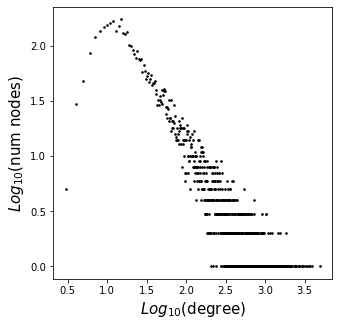

In [15]:
#Run the funtion
fig = plot_degree_numbers_and_counts(degree_numbers, degree_counts)

For a given node $u$ in our network $G$, let $\Gamma(u)$ denote the set of $u$'s neighbors, i.e., set of nodes linked to $u$.

In this part, we'll be utilizing the Jaccard coefficient similarity function on neighborhoods of nodes to determine the foods most likely to link to one anothers, i.e., appear in a recipe together heretofore unseen.

In particular, the Jaccard coefficient of nodes $u$ and $v$ is defined as

$$\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$$

where $\Gamma(u)$ denotes the set of neighbors of $u$ and can be computed through networkx utilizing the `nx.jaccard_coefficient(G, ebunch=None)` utility.

Lets apply the `nx.jaccard_coefficient()` function to a few seemingly dispirate and a few seemingly similar ingredients (to your sensibilities).

Lets look at the Jaccard coefficient between Salmon and Chocolate

In [16]:

jac = nx.jaccard_coefficient(recipe_graph, ebunch=[("salmon", "chocolate")])
for u, v, p in jac:
    print(u, v, p)

salmon chocolate 0.08352668213457076


Lets look at the Jaccard coefficient between Coffee and Chocolate

In [17]:
# C6:Inline(1/3)
jac = nx.jaccard_coefficient(recipe_graph, ebunch=[("coffee", "chocolate")])
for u, v, p in jac:
    print(u, v, p)

coffee chocolate 0.22459893048128343


We can see that the two ingredients we think of as more similar "coffee" and "chocolate" have a higher similarity score than those we think of as less similar.

Next, lets write a function called `unlinked`, which takes a NetworkX `graph` and the name of a node in the graph (`node_name`). This function should create a list of node `names` using the `graph.nodes()` method and corresponding adjacency matrtix from `nx.to_numpy_matrix(...)`. The function should then return a list of the names of all other nodes (ingredients) for which the node (queried ingredient, `node_name`) shares no link.

In [18]:
def unlinked(graph, node_name):
    names = list(graph.nodes())
    indx = names.index(node_name)
    unlinked_nodes = []
    mat = np.array(nx.to_numpy_matrix(graph))
    for count, i in enumerate(mat[indx]):
        if i == 0:
            unlinked_nodes.append(names[count])
    return unlinked_nodes

Let's test this function by using it to evaluate the outputs for 'salt' and 'chocolate'. Let's also look at the size of the outputs for each.

In [19]:
#Run the function
unlinked_from_salt = unlinked(recipe_graph, "salt")
unlinked_from_chocolate = unlinked(recipe_graph, "chocolate")

print("Unlinked from salt:", unlinked_from_salt[:5])
print("Unlinked from chocolate:", unlinked_from_chocolate[:5])
print()
print("# of nodes unlinked from salt: {}".format(len(unlinked_from_salt)))
print("# of nodes unlinked from chocolate: {}".format(len(unlinked_from_chocolate)))

Unlinked from salt: ['hibiscus', 'lamb racks', 'blood sausage', 'gluten-free penne', 'margarine spread']
Unlinked from chocolate: ['savory', 'peppered bacon', 'mandarin orange segments', 'white vinegar', 'snip fresh dill']

# of nodes unlinked from salt: 1834
# of nodes unlinked from chocolate: 6515


It makes sense that the items such as ginger beer listed above would be unlinked from salt and pork meat would be unlinked from chocolate 

Finally, I will write a function called `likely_ingredients` that takes two arguments, a networkx `graph` and the name of a node (`node_name`). Given these inputs the function should apply the `unlinked` function to compute all the nodes that are unlinked from the target node. Then the function should use the `nx.jaccard_coefficient(...)` function to compute the jaccard coefficient between our target node and each of the nodes in its unlinked list. Finally, the function should sort these values by the Jaccard coefficient and return the resulting list (`sorted_similarities`).

In [20]:
def likely_ingredients(graph, node_name):
    unl_list = unlinked(graph,node_name)
    similarities = []
    for i in unl_list:
        jac = nx.jaccard_coefficient(graph, ebunch=[(node_name, i)])
        for u, v, p in jac:
            similarities.append((u, v, p))
    sorted_similarities = sorted(similarities, key = lambda x:x[2], reverse = True)
    return sorted_similarities

Now, let's test our functinon by using it to compute the top 5 most similar unlinked nodes for "whisky" and "chocolate".


In [21]:
from pprint import pprint
pprint(likely_ingredients(recipe_graph, "whiskey")[:5])
print()
pprint(likely_ingredients(recipe_graph, "chocolate")[:5])

[('whiskey', 'apple cider', 0.25663716814159293),
 ('whiskey', 'Irish whiskey', 0.24489795918367346),
 ('whiskey', 'firmly packed light brown sugar', 0.24203821656050956),
 ('whiskey', 'dark corn syrup', 0.24124513618677043),
 ('whiskey', 'pitted date', 0.24)]

[('chocolate', 'instant espresso powder', 0.2540192926045016),
 ('chocolate', 'whole almonds', 0.24731182795698925),
 ('chocolate', 'mexican chocolate', 0.23825503355704697),
 ('chocolate', 'semi-sweet chocolate morsels', 0.23636363636363636),
 ('chocolate', 'coffee liqueur', 0.2283464566929134)]


This analysis provides information useful for determining substitutions and constructing new recipe pairings

## Phase 3: Connecting Ingredients with Wines

Lets read the recipes file again as cuisines

In [33]:
cuisines = json.load(open("./data/train.json", "r"))
cuisines[:3]

[{'id': 10259,
  'cuisine': 'greek',
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']},
 {'id': 25693,
  'cuisine': 'southern_us',
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil']},
 {'id': 20130,
  'cuisine': 'filipino',
  'ingredients': ['eggs',
   'pepper',
   'salt',
   'mayonaise',
   'cooking oil',
   'green chilies',
   'grilled chicken breasts',
   'garlic powder',
   'yellow onion',
   'soy sauce',
   'butter',
   'chicken livers']}]

We will expand each wine variety's list of foods to include any co-appearing in the recipes found in the above Kaggle dataset. Make sure to record how often ingredients in the Kaggle recipes occured alongside foods in the wine variety list.


In [41]:
from collections import Counter
ingredients = []
#count up all the ingredients in the cuisine dictionary
for i in cuisines:
    for j in i["ingredients"]:
        ingredients.append(j)
    
ingcount = Counter(ingredients)

wines = dict(winedict)
pairings = []
for wine in wines:
    for cat in wines[wine]:
        templist = wines[wine][cat]
        wines[wine][cat] = {}
        for i in templist:
            if i in ingcount.elements():
                wines[wine][cat][i] = ingcount[i]
            else:
                wines[wine][cat][i] = 0            
#wines
limit2 = wines.items()
list(limit2)[:3]

[('Sauvignon Blanc',
  {'Cheese/nuts': {'feta': 0, 'goat cheese': 169, 'pine nuts': 0},
   'Meat/poultry': {'chicken': 982, 'turkey': 62, 'pork': 300},
   'Seafood': {'fatty white fish': 0,
    'oysters': 60,
    'scallops': 38,
    'lobster': 50,
    'shrimp': 912,
    'sushi': 0},
   'Fruits and Veggies': {'citrus': 2, 'green apple': 0, 'asparagus': 230},
   'Herbs and Spices': {'chives': 206, 'tarragon': 35, 'cilantro': 1142},
   'Sauces': {'citrus and light cream sauces': 0},
   'Desserts': {'sorbet': 7, 'key lime pie': 0, 'meringue': 9, 'mango': 268}}),
 ('Chardonnay',
  {'Cheese': {'mild': 0,
    'semi-soft cheeses with unoaked Chardonnay; asiago': 0,
    'havarti': 1,
    'Stilton or other blue-veined cheeses with oaky Chardonnay': 0},
   'Nuts': {'almonds and nearly any toasted nut': 0},
   'Meat/poultry': {'veal': 31, 'chicken': 982, 'pork': 300},
   'Seafood': {'halibut': 26, 'shrimp': 912, 'crab': 37, 'lobster': 50},
   'Fruits and Veggies': {'potato': 0, 'apple': 0, 'squash

We'd also like to incorporate a wine review dataset. Lets download the dataset, found at: https://www.kaggle.com/zynicide/wine-reviews. Specifically, we will utilize the file: `winemag-data-130k-v2.csv` to link each of the scraped wines found in `wines` to the specific names of the wines which are of that variety (i.e., for the Sauvignon wine, we'll create a list of all the wines with `variety` column that say Sauvignon, and attach them to the `wines` object from before).

In [45]:
import pandas as pd
winemag = pd.read_csv("./data/winemag-data-130k-v2.csv", index_col = 0)

for wine in wines:
    tempdf = winemag[winemag["variety"] == wine]
    winelist = list(tempdf["title"])
    wines[wine]["Names"] = winelist[:10]
wines
limit3 = wines.items()
list(limit3)[:2]

[('Sauvignon Blanc',
  {'Cheese/nuts': {'feta': 0, 'goat cheese': 169, 'pine nuts': 0},
   'Meat/poultry': {'chicken': 982, 'turkey': 62, 'pork': 300},
   'Seafood': {'fatty white fish': 0,
    'oysters': 60,
    'scallops': 38,
    'lobster': 50,
    'shrimp': 912,
    'sushi': 0},
   'Fruits and Veggies': {'citrus': 2, 'green apple': 0, 'asparagus': 230},
   'Herbs and Spices': {'chives': 206, 'tarragon': 35, 'cilantro': 1142},
   'Sauces': {'citrus and light cream sauces': 0},
   'Desserts': {'sorbet': 7, 'key lime pie': 0, 'meringue': 9, 'mango': 268},
   'Names': ['Envolve 2011 Sauvignon Blanc (Sonoma Valley)',
    'Robert Hall 2011 Sauvignon Blanc (Paso Robles)',
    'Trump 2011 Sauvignon Blanc (Monticello)',
    'Sevtap 2015 Golden Horn Sauvignon Blanc (Santa Ynez Valley)',
    'Stoneleigh 2008 Sauvignon Blanc (Marlborough)',
    'Long Flat 2006 Destinations Sauvignon Blanc (Adelaide Hills)',
    'Elena Walch 2002 Castel Ringberg Sauvignon Blanc (Alto Adige)',
    'Borgo Convent

We will write a function which allows the user to input a list of ingredients and also a choice of ingredient category (such as "Cheese/nuts"), and outputs a list of all wine names that pair with these ingredients. Due to memory constraints, this function won't incorporate the additional ingredients we obtained from the Kaggle dataset.

In [46]:
def getwines(category, ingredient_list):
    wineout = []
    ingset = set(ingredient_list)
    for wine in wines:
        if category in wines[wine]:
            ingset2 = set(wines[wine][category].keys())
            if (ingset.issubset(ingset2)):
                wineout.append(wines[wine]["Names"])
    if len(wineout) == 0:
        print("Sorry no wines for you")
        return
    else:
        return wineout
getwines("Cheese/nuts", ["feta", "goat cheese"])

[['Envolve 2011 Sauvignon Blanc (Sonoma Valley)',
  'Robert Hall 2011 Sauvignon Blanc (Paso Robles)',
  'Trump 2011 Sauvignon Blanc (Monticello)',
  'Sevtap 2015 Golden Horn Sauvignon Blanc (Santa Ynez Valley)',
  'Stoneleigh 2008 Sauvignon Blanc (Marlborough)',
  'Long Flat 2006 Destinations Sauvignon Blanc (Adelaide Hills)',
  'Elena Walch 2002 Castel Ringberg Sauvignon Blanc (Alto Adige)',
  'Borgo Conventi 2002 I Fiori del Borgo Sauvignon Blanc (Collio)',
  "Ceago Vinegarden 2001 Kathleen's Vineyard Sauvignon Blanc (Mendocino County)",
  'Vinoce 2001 Sauvignon Blanc (Rutherford)']]